In [ ]:
""""
Implementation of gradient-descent ascent methods for CMDPs (in policy space)
"""
import sys
from einops import rearrange
import numpy as np
import numpy.random as rn
from scipy.special import softmax
from numpy import linalg
sys.path.append('../..')
from examples.safe_PCE import *

                     
def pi_to_theta(pi, neg_inf=-1e9):
    """
    Convert a row-stochastic policy pi (shape (n,m)) to a theta such that
    softmax(theta[s,:]) == pi[s,:] for each row s.
    Entries with pi==0 receive a large negative value (approx -inf).
    """
    theta = np.where(pi > 0, np.log(pi), neg_inf)
    return theta
    
def gradient_logpi(env, policy, s, a):
    temp = np.zeros((env.n, env.m))
    temp[s, :] = - policy[s, :]
    temp[s, a] += 1
    
    return rearrange(temp, 's a -> (s a)')

def LB_rollout(env, sample_n: int, policy: np.ndarray):
    """
    Generate N trajectories of length T,
    following the given policy. Return trajectories and corresponding total discounted rewards.
    :param sample_n: Number of trajectories.
    :param T: Length of an episode.
    :param policy: Numpy array pi(a|s)_(s,a), shape (n, m).
    :param nu0: Different initial state distribution.
    :return: Trajectories, tot_rewards.
    """
    nu0 = env.nu0
    rewards_gradient = np.zeros((sample_n, env.n * env.m))
    costs_gradient = np.zeros((sample_n, env.n * env.m))
    costs = np.zeros(sample_n)
    # sample trajectories
    for n in range(sample_n):
        logpi = np.zeros((env.n * env.m))
        s = rn.choice(env.n, p = nu0)
        for t in range(600):      
            # sample from policy
            a = rn.choice(env.m, p = policy[s, :])
            # sample from dynamics
            s_next = rn.choice(env.n, p = env.P[s, a, :]) 
            r = env.r[s, a]
            c = env.Psi[s, a, 0]
            costs[n] += env.gamma**t * c
            logpi += gradient_logpi(env, policy, s, a)
            rewards_gradient[n, :] += env.gamma**t * r * logpi 
            costs_gradient[n, :] += env.gamma**t * c * logpi
            s = s_next
    rewards_gradient = np.mean(rewards_gradient, axis = 0)
    costs_gradient = np.mean(costs_gradient, axis = 0)
    costs = env.b - np.mean(costs)
            
    return  costs, rewards_gradient, costs_gradient
    
def softmaxpolicy(env, theta):
    """
    PG for softmax policy parametrization.
    """
    policy = np.zeros((env.n, env.m))
    theta = np.reshape(theta, (env.n, env.m))
    for s in range(env.n):
        policy[s, :] = softmax(theta[s, :])
    return policy

def LB_PG(env, theta: np.ndarray, max_iters = 2000):
    """
    Running log barrier method for max_iters rounds
    """
    max_iters = int(max_iters)
    regret = 0
    _, u_optimal, _ = LP(env)
    reward_regret = np.zeros(max_iters)
    cost_hist = np.zeros(max_iters)
    it = 0
    eta = 0.1
    sample_n = 500
    setpsize = 4
    while it < max_iters :
        policy = softmaxpolicy(env, theta)
        # handle scalar vs length-1 array cost returned by value_function_r_c
        r_val, c_val = value_function_r_c(env, policy)
        if c_val > env.b:
            print("Constraint violated!")
            break
        regret = reward_regret[it - 1]
        # regret because of batch sampling
        for i in range(sample_n):
            idx = it + i
            if idx >= max_iters:
                break
            reward_regret[idx] = regret + (u_optimal - r_val) * (i + 1)
            cost_hist[idx] = np.asarray(c_val).ravel()[0]
        # rollout for gradients / LB quantities
        cost_lb, rewards_gradient, costs_gradient = LB_rollout(env, sample_n, policy)
        cost_lb = np.clip(cost_lb, 0.05, None)
        lb_gradient = rewards_gradient - eta * costs_gradient / (cost_lb +  1e-8)
        lb_gradient = np.reshape(lb_gradient, theta.shape)
        theta = theta + setpsize * lb_gradient  
        it += sample_n
        sample_n = max(min(1 / cost_lb ** 2, 500), 3000)
    return reward_regret, cost_hist

Saved r_log and c_log to data/r_c_history_log_barrier.pkl


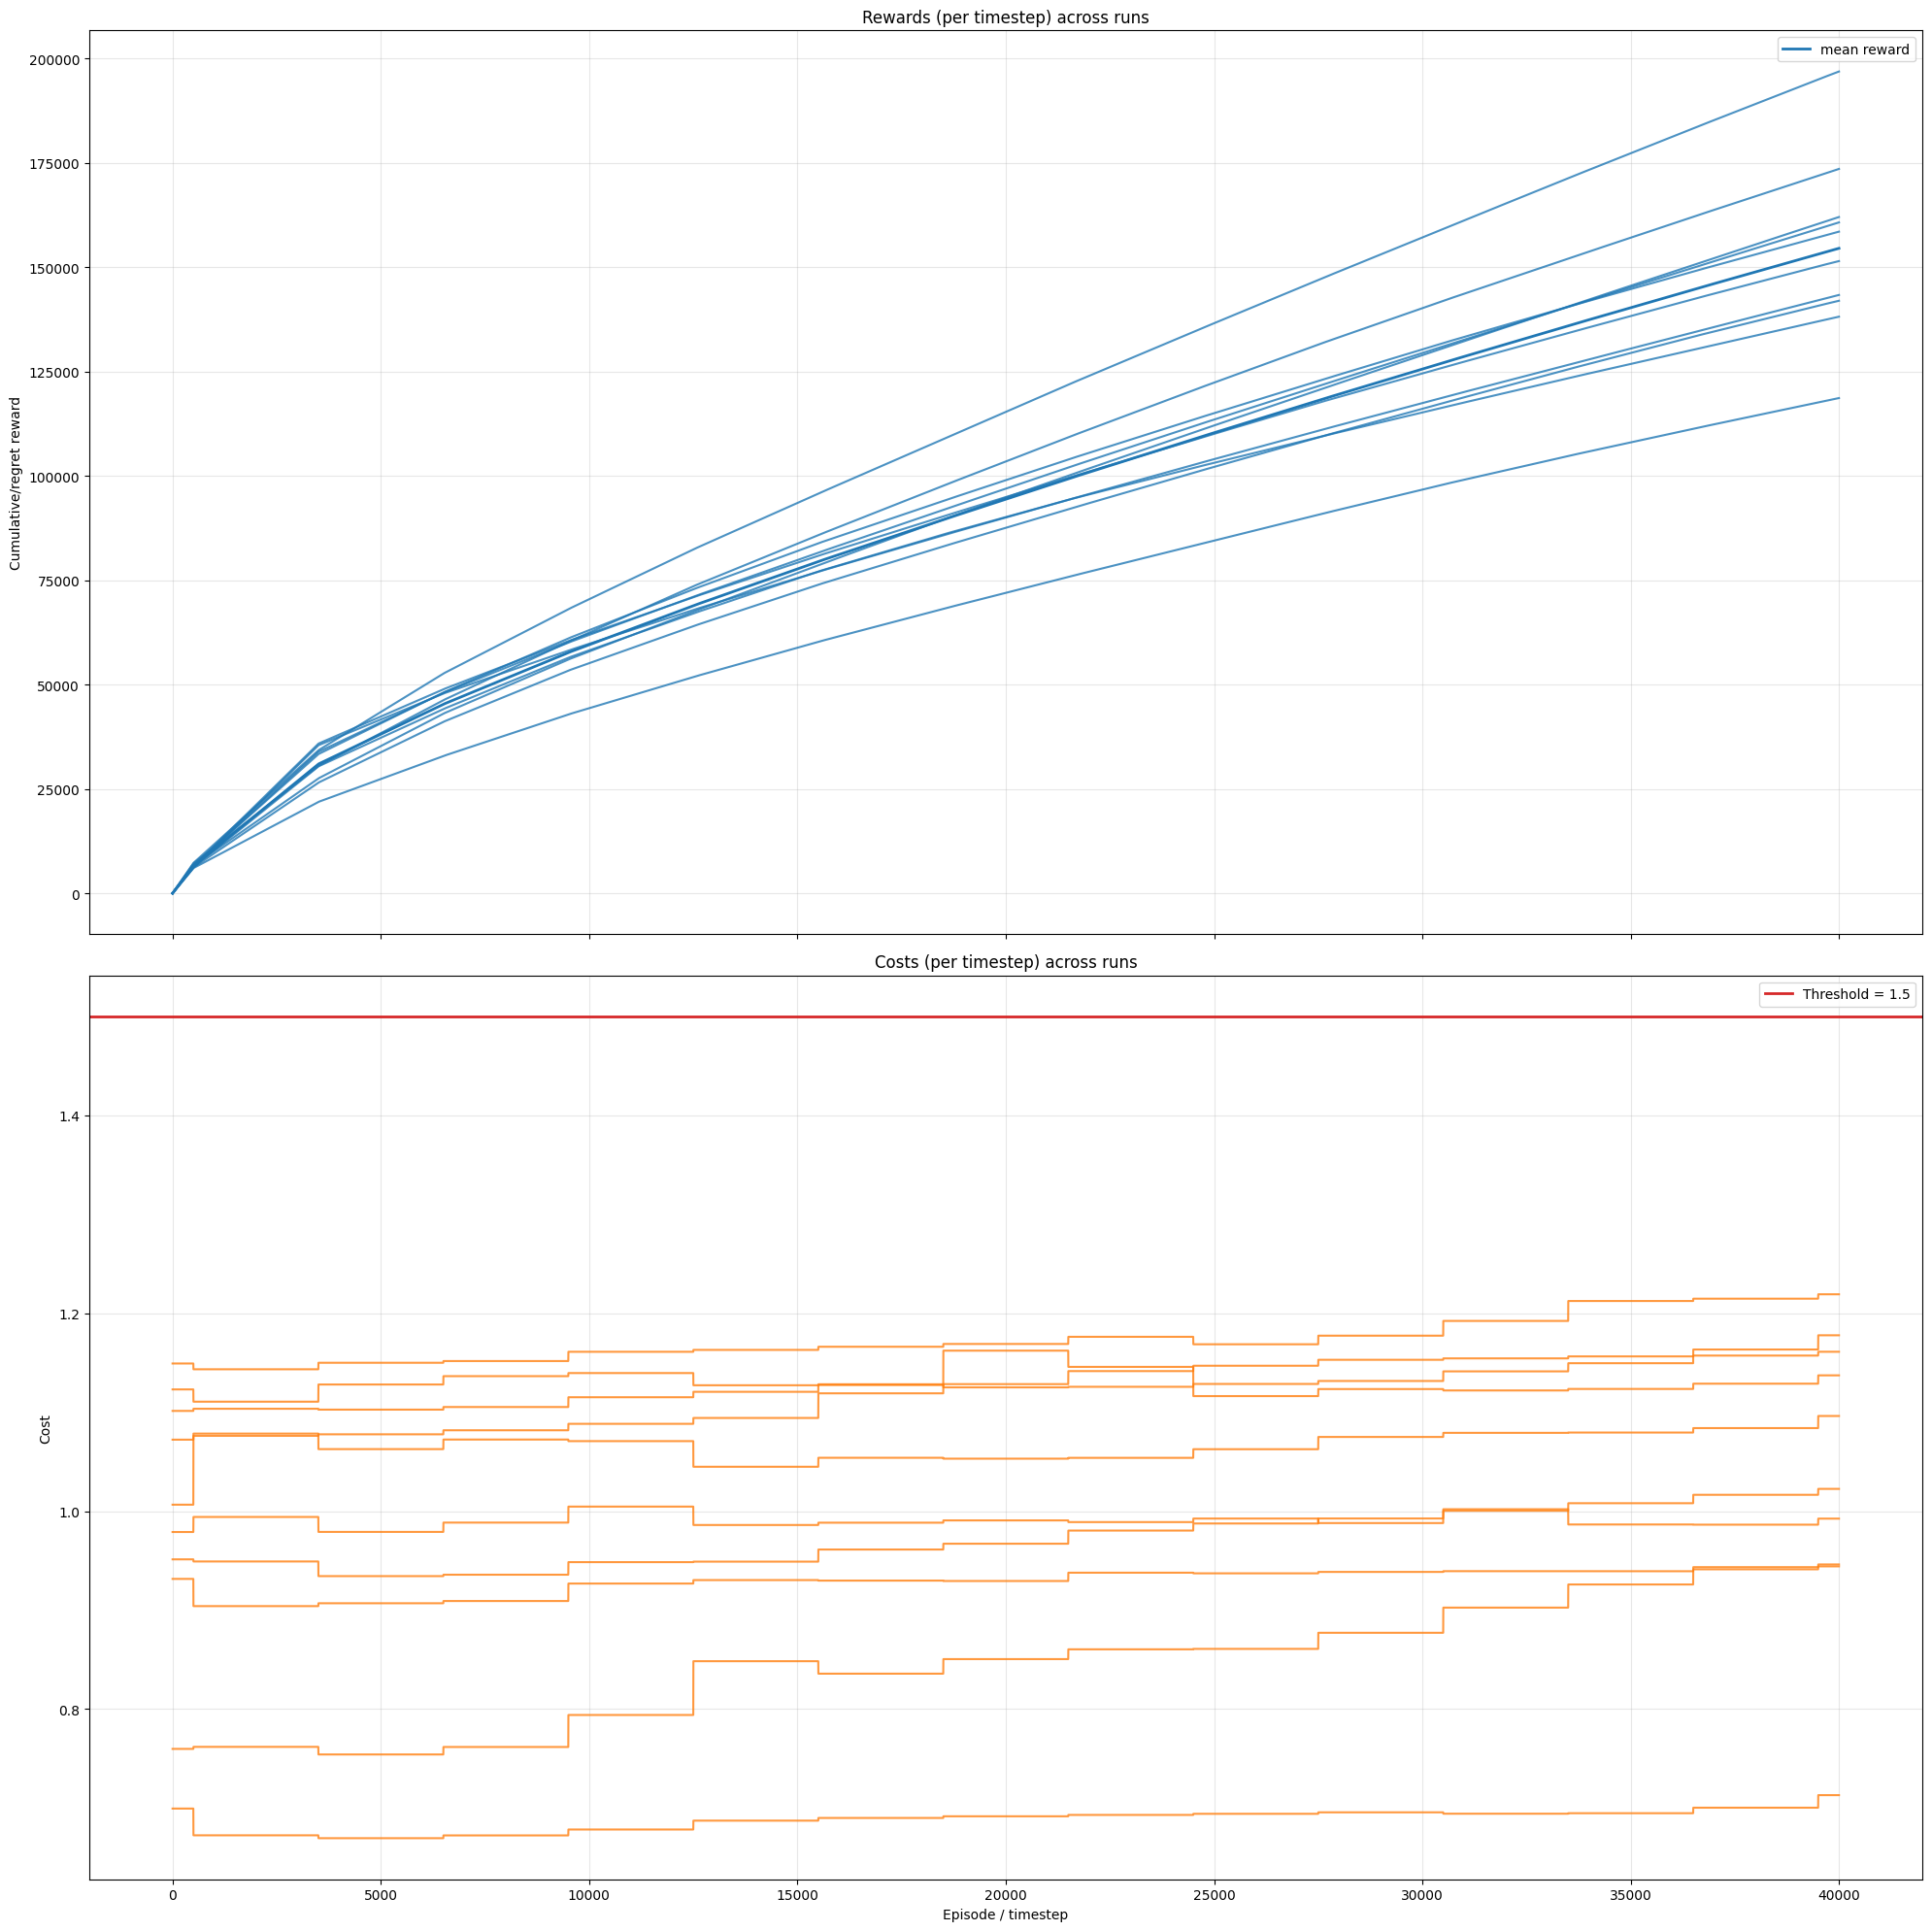

In [2]:
noise_arr = [0.33994760, 0.25363799, 0.31864008, 0.30796535, 0.33609112, 0.33084822, 0.31335413, 0.30405411, 0.34453611, 0.26760585]
# Constrauct safe policy with high entropy such that it encourages exploration for policy gradient approach
env = make_env(0.4)  
beta = 8
eta_p = (1-env.gamma) /beta * 1
eta_xi = 0.1
policy, u_s, v_s = cmdp_gda(env, beta , eta_p, eta_xi, max_iters=1e4, tol=-1, mode='alt_gda',
                                    n_v_tot_eval_steps=50, n_v_c_eval_steps=50, logging=False, check_steps=1000)
theta_s = pi_to_theta(policy)
tot_e = 40000
r_log = np.zeros((len(noise_arr), tot_e))   # use tuple shape
c_log = np.zeros((len(noise_arr), tot_e)) 

for i, noise in enumerate(noise_arr):
    env = make_env(noise)
    r_log[i, :], c_log[i, :] = LB_PG(env, theta = theta_s, max_iters = tot_e)
with open("data/r_c_history_log_barrier.pkl", "wb") as f:  # Save as a pickle file
    pickle.dump({"r_log": r_log, "c_log": c_log}, f)
print("Saved r_log and c_log to data/r_c_history_log_barrier.pkl")

# Plot reward and cost histories (handles multiple runs)
n_runs, T = r_log.shape

fig, axes = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

x = np.arange(T)

# Rewards
for i in range(n_runs):
	axes[0].plot(x, r_log[i], color='C0', alpha=0.8)
axes[0].plot(x, np.mean(r_log, axis=0), color='C0', lw=2, label='mean reward')
axes[0].set_ylabel('Cumulative/regret reward')
axes[0].set_title('Rewards (per timestep) across runs')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Costs
for i in range(n_runs):
	axes[1].plot(x, c_log[i], color='C1', alpha=0.8)
axes[1].set_ylabel('Cost')
axes[1].set_xlabel('Episode / timestep')
axes[1].set_title('Costs (per timestep) across runs')
axes[1].axhline(y =  1.5, color = 'tab:red',label = 'Threshold = 1.5', linewidth=2)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("plots/reg_and_cost_log_barrier.png", format='png', dpi=800)  # Save with 800 dpi
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import visualization.gridworld_vis as gv
import math
env = make_env(0.4)  
beta = 8
eta_p = (1-env.gamma) /beta * 1
eta_xi = 0.3
policy, u_s, v_s = cmdp_gda(env, beta , eta_p, eta_xi, max_iters=1e4, tol=-1, mode='alt_gda',
                                    n_v_tot_eval_steps=50, n_v_c_eval_steps=50, logging=False, check_steps=1000)
theta = pi_to_theta(policy)
# Generate and save the figure for safe policy
constraint_patches = np.array([[[2,1],[1,4]], [[4,1],[1,4]]])
figure = gv.plot_gridworld(env, policy, f'Optimal value {round(float(u_s),2)} and cost {np.round(v_s[-1],2)}', env.grid_width, env.grid_height, values=env.r[:,1], constraints=constraint_patches, logging=False)
figure.set_size_inches(5, 5)  # Set figure size
plt.show()